In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/Phase Project

/content/drive/MyDrive/Phase Project


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
import os

PyTorch Version:  1.7.0+cu101
Torchvision Version:  0.8.1+cu101


In [ ]:
!pip install efficientnet_pytorch

In [ ]:
from efficientnet_pytorch import EfficientNet
model_name = 'efficientnet-b0'
model = EfficientNet.from_pretrained(model_name)
image_size = EfficientNet.get_image_size(model_name)
print(image_size)

Loaded pretrained weights for efficientnet-b0
224


##Dataset Exploration

In [ ]:
#Transformations
from PIL.Image import BICUBIC

transform_train = transforms.Compose([
    transforms.Resize(224, BICUBIC),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.Resize(224, BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010))
])

In [ ]:
dataset = torchvision.datasets.CIFAR10(root = './data', train=True, transform= transform_train, download=True)
testset = torchvision.datasets.CIFAR10(root = './data', train=False, transform= transform_test,  download=True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
classname = dataset.classes
print(classname)
print(len(classname))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
10


device(type='cuda', index=0)

['deer', 'dog', 'deer', 'automobile', 'horse', 'ship', 'bird', 'deer', 'dog', 'airplane', 'cat', 'automobile', 'deer', 'airplane', 'dog', 'dog', 'bird', 'automobile', 'dog', 'horse', 'bird', 'frog', 'airplane', 'automobile', 'deer', 'automobile', 'frog', 'deer', 'deer', 'frog', 'frog', 'dog', 'ship', 'cat', 'cat', 'bird', 'bird', 'bird', 'dog', 'deer', 'horse', 'deer', 'horse', 'frog', 'dog', 'automobile', 'ship', 'ship', 'cat', 'ship', 'horse', 'cat', 'dog', 'deer', 'ship', 'truck', 'deer', 'horse', 'frog', 'frog', 'deer', 'ship', 'cat', 'dog', 'horse', 'automobile', 'deer', 'airplane', 'frog', 'dog', 'cat', 'frog', 'horse', 'cat', 'airplane', 'deer', 'airplane', 'deer', 'cat', 'frog', 'airplane', 'truck', 'automobile', 'deer', 'deer', 'automobile', 'airplane', 'ship', 'bird', 'horse', 'truck', 'dog', 'truck', 'ship', 'horse', 'bird', 'airplane', 'frog', 'horse', 'automobile', 'horse', 'frog', 'dog', 'horse', 'horse', 'ship', 'ship', 'airplane', 'dog', 'truck', 'truck', 'bird', 'horse

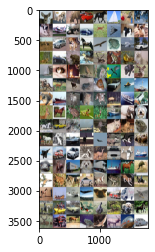

In [ ]:
trainset = dataset
train = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers = 2)
test = torch.utils.data.DataLoader(testset, batch_size = 128, shuffle=True, num_workers = 2)


out, label = next(iter(train))
img = torchvision.utils.make_grid(out)
img = img.numpy().transpose((1, 2, 0))
mean = np.array([0.4914, 0.4822, 0.4465])
std = np.array([0.2023, 0.1994, 0.2010])
img = std* img + mean
img = np.clip(img, 0, 1)
plt.imshow(img)
print([classname[x] for x in label])

In [ ]:
dataset_size = len(trainset)
classes = dataset.classes
num_classes = len(dataset.classes)
img_dict = {}
for i in range(num_classes):
    img_dict[classes[i]] = 0

for i in range(dataset_size):
    img, label = dataset[i]
    img_dict[classes[label]] += 1

img_dict

{'airplane': 5000,
 'automobile': 5000,
 'bird': 5000,
 'cat': 5000,
 'deer': 5000,
 'dog': 5000,
 'frog': 5000,
 'horse': 5000,
 'ship': 5000,
 'truck': 5000}

In [ ]:
dataset_size = len(testset)
classes = dataset.classes
num_classes = len(dataset.classes)
img_dict = {}
for i in range(num_classes):
    img_dict[classes[i]] = 0

for i in range(dataset_size):
    img, label = dataset[i]
    img_dict[classes[label]] += 1

img_dict

{'airplane': 1005,
 'automobile': 974,
 'bird': 1032,
 'cat': 1016,
 'deer': 999,
 'dog': 937,
 'frog': 1030,
 'horse': 1001,
 'ship': 1025,
 'truck': 981}

Dataset is well balanced

#Model Designing

First, using as fixed feature extractor, training only last(linear layer)

In [ ]:
model.to(device)

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

In [ ]:
for param in model.parameters():
    param.requires_grad = False
    
num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, 10).cuda()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model._fc.parameters(), lr=0.1, momentum=0.9)

from torch.optim import lr_scheduler
learningrate_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

4,020,358 total parameters.
12,810 training parameters.


In [ ]:
#Checkpoint

check_path = '/content/drive/My Drive/Phase Project'

In [ ]:
best_acc = 0
def train_(model, train, val, optimizer, criterion, scheduler, device, epochs):
    loss_train_ = []
    loss_test_ = []
    for epoch in range(epochs):
        model.train()
        loss_train = 0.0
        correct = 0
        total = 0
        for inputs, targets in train:
            inputs = inputs.to(device)
            targets = targets.to(device)
            total += targets.size(0)
            optimizer.zero_grad()
            with torch.set_grad_enabled(True):
              outputs = model(inputs)
              _, preds = torch.max(outputs,1)
              loss = criterion(outputs, targets)
              loss.backward()
              optimizer.step()
            loss_train = loss_train + loss.item() * inputs.size(0)
            correct = correct + torch.sum(preds == targets.data)
        scheduler.step() 
        print('Epoch: [%d/%d] Train Loss: %.3f | Train Acc: %.3f%% (%d/%d)'
          %(epoch, epochs, torch.true_divide(loss_train, len(trainset)), 100* torch.true_divide(correct, total) , correct, total))
        loss_train_.append(torch.true_divide(loss_train,len(trainset) ))


        model.eval()
        loss_val = 0.0
        corr = 0
        tot = 0
        global best_acc
        for input, target in test:
            input = input.to(device)
            target = target.to(device)
            tot += target.size(0)
            with torch.no_grad():
              out = model(input)
              _, pred = torch.max(out,1)
              loss = criterion(out, target)
            loss_val = loss_val + loss.item()* input.size(0)
            corr = corr + torch.sum(pred == target.data )

        print('Epoch: [%d/%d] Val Loss: %.3f | Val Acc: %.3f%% (%d/%d)'
          %(epoch, epochs, torch.true_divide(loss_val, len(testset)), 100* torch.true_divide(corr,tot) , corr, tot))
        loss_test_.append(torch.true_divide(loss_val,len(testset) ))
        acc = 100* torch.true_divide(corr,tot)
        if acc > best_acc:
           print('Saving the model..')
           state = {
             'model': model.state_dict(),
             'acc': acc,
             'epoch': epoch,
              }
           if not os.path.isdir('checkpoint'):
                  os.mkdir('checkpoint')
                  torch.save(state, './checkpoint/ckpt.pth')
           best_acc = acc

    return loss_train_, loss_test_    

Batch Size 32

In [ ]:
train = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers = 2)
test = torch.utils.data.DataLoader(testset, batch_size = 32, shuffle=True, num_workers = 2)
model = EfficientNet.from_pretrained(model_name)
model.to(device)
for param in model.parameters():
    param.requires_grad = False
    
num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, 10).cuda()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model._fc.parameters(), lr=0.1, momentum=0.9)

from torch.optim import lr_scheduler
learningrate_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

loss1 , loss2 = train_(model, train, test, optimizer, criterion, learningrate_scheduler, device , epochs = 20)

Loaded pretrained weights for efficientnet-b0
Epoch: [0/20] Train Loss: 0.889 | Train Acc: 74.542% (37271/50000)
Epoch: [0/20] Val Loss: 0.577 | Val Acc: 83.010% (8301/10000)
Saving the model..
Epoch: [1/20] Train Loss: 0.898 | Train Acc: 76.086% (38043/50000)
Epoch: [1/20] Val Loss: 0.611 | Val Acc: 83.290% (8329/10000)
Saving the model..
Epoch: [2/20] Train Loss: 0.921 | Train Acc: 76.384% (38192/50000)
Epoch: [2/20] Val Loss: 0.619 | Val Acc: 82.560% (8256/10000)
Saving the model..
Epoch: [3/20] Train Loss: 0.910 | Train Acc: 76.912% (38456/50000)
Epoch: [3/20] Val Loss: 0.694 | Val Acc: 81.950% (8195/10000)
Saving the model..
Epoch: [4/20] Train Loss: 0.946 | Train Acc: 76.476% (38238/50000)
Epoch: [4/20] Val Loss: 0.649 | Val Acc: 82.800% (8280/10000)
Saving the model..
Epoch: [5/20] Train Loss: 0.924 | Train Acc: 76.972% (38486/50000)
Epoch: [5/20] Val Loss: 0.638 | Val Acc: 83.050% (8305/10000)
Saving the model..
Epoch: [6/20] Train Loss: 0.917 | Train Acc: 76.934% (38467/50000)

In [ ]:
train_(model, train, test, optimizer, criterion, learningrate_scheduler, device , epochs = 20)

Epoch: [0/20] Train Loss: 0.518 | Train Acc: 82.686% (41343/50000)
Epoch: [0/20] Val Loss: 0.409 | Val Acc: 86.220% (8622/10000)
Saving the model..
Epoch: [1/20] Train Loss: 0.515 | Train Acc: 82.540% (41270/50000)
Epoch: [1/20] Val Loss: 0.410 | Val Acc: 86.330% (8633/10000)
Saving the model..
Epoch: [2/20] Train Loss: 0.517 | Train Acc: 82.648% (41324/50000)
Epoch: [2/20] Val Loss: 0.405 | Val Acc: 86.130% (8613/10000)
Epoch: [3/20] Train Loss: 0.521 | Train Acc: 82.548% (41274/50000)
Epoch: [3/20] Val Loss: 0.411 | Val Acc: 86.280% (8628/10000)
Saving the model..
Epoch: [4/20] Train Loss: 0.486 | Train Acc: 83.452% (41726/50000)
Epoch: [4/20] Val Loss: 0.387 | Val Acc: 87.220% (8722/10000)
Saving the model..
Epoch: [5/20] Train Loss: 0.474 | Train Acc: 83.944% (41972/50000)
Epoch: [5/20] Val Loss: 0.383 | Val Acc: 87.280% (8728/10000)
Saving the model..
Epoch: [6/20] Train Loss: 0.471 | Train Acc: 83.982% (41991/50000)
Epoch: [6/20] Val Loss: 0.380 | Val Acc: 87.320% (8732/10000)
Sa

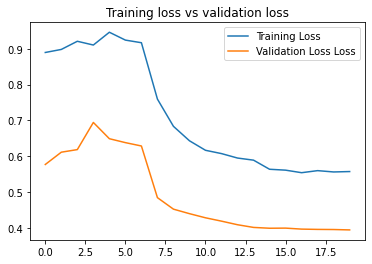

In [ ]:
x = [i for i in np.arange(0, 20)]
plt.plot(x, loss1, Label = 'Training Loss')
plt.plot(x, loss2, Label = 'Validation Loss Loss')
plt.legend(loc = 'upper right')
plt.title("Training loss vs validation loss")
plt.show()

#Batch Size 8

In [ ]:
train = torch.utils.data.DataLoader(trainset, batch_size=8, shuffle=True, num_workers = 2)
test = torch.utils.data.DataLoader(testset, batch_size = 8, shuffle=True, num_workers = 2)

train_(model, train, test, optimizer, criterion, learningrate_scheduler, device , epochs = 20)

Epoch: [0/20] Train Loss: 3.361 | Train Acc: 64.106% (32053/50000)
Epoch: [0/20] Val Loss: 2.133 | Val Acc: 78.270% (7827/10000)
Saving the model..
Epoch: [1/20] Train Loss: 3.805 | Train Acc: 66.532% (33266/50000)
Epoch: [1/20] Val Loss: 2.011 | Val Acc: 79.000% (7900/10000)
Saving the model..
Epoch: [2/20] Train Loss: 3.791 | Train Acc: 67.086% (33543/50000)
Epoch: [2/20] Val Loss: 2.242 | Val Acc: 78.530% (7853/10000)
Saving the model..
Epoch: [3/20] Train Loss: 3.845 | Train Acc: 67.428% (33714/50000)
Epoch: [3/20] Val Loss: 2.187 | Val Acc: 78.180% (7818/10000)
Epoch: [4/20] Train Loss: 3.895 | Train Acc: 67.168% (33584/50000)
Epoch: [4/20] Val Loss: 2.407 | Val Acc: 77.660% (7766/10000)
Epoch: [5/20] Train Loss: 3.878 | Train Acc: 66.962% (33481/50000)
Epoch: [5/20] Val Loss: 2.293 | Val Acc: 78.580% (7858/10000)
Saving the model..
Epoch: [6/20] Train Loss: 3.884 | Train Acc: 67.314% (33657/50000)
Epoch: [6/20] Val Loss: 2.193 | Val Acc: 78.700% (7870/10000)
Saving the model..
Ep

([tensor(3.3610),
  tensor(3.8052),
  tensor(3.7910),
  tensor(3.8445),
  tensor(3.8949),
  tensor(3.8785),
  tensor(3.8838),
  tensor(3.9413),
  tensor(3.8602),
  tensor(3.9087),
  tensor(2.8330),
  tensor(2.2651),
  tensor(1.9757),
  tensor(1.6955),
  tensor(1.4871),
  tensor(1.3457),
  tensor(1.2061),
  tensor(1.1054),
  tensor(1.0332),
  tensor(0.9664)],
 [tensor(2.1331),
  tensor(2.0106),
  tensor(2.2420),
  tensor(2.1870),
  tensor(2.4066),
  tensor(2.2933),
  tensor(2.1926),
  tensor(2.2242),
  tensor(2.2256),
  tensor(2.3177),
  tensor(1.5467),
  tensor(1.3231),
  tensor(1.1855),
  tensor(1.0078),
  tensor(0.8790),
  tensor(0.7820),
  tensor(0.7330),
  tensor(0.6700),
  tensor(0.6412),
  tensor(0.5853)])

#Batch size 128

In [ ]:
train = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers = 2)
test = torch.utils.data.DataLoader(testset, batch_size = 128, shuffle=True, num_workers = 2)
model = EfficientNet.from_pretrained(model_name)
model.to(device)
for param in model.parameters():
    param.requires_grad = False
    
num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, 10).cuda()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model._fc.parameters(), lr=0.1, momentum=0.9)

from torch.optim import lr_scheduler
learningrate_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

loss1 , loss2 = train_(model, train, test, optimizer, criterion, learningrate_scheduler, device , epochs = 20)

Loaded pretrained weights for efficientnet-b0
Epoch: [0/20] Train Loss: 0.638 | Train Acc: 78.854% (39427/50000)
Epoch: [0/20] Val Loss: 0.477 | Val Acc: 84.050% (8405/10000)
Saving the model..
Epoch: [1/20] Train Loss: 0.538 | Train Acc: 81.974% (40987/50000)
Epoch: [1/20] Val Loss: 0.418 | Val Acc: 85.990% (8599/10000)
Saving the model..
Epoch: [2/20] Train Loss: 0.530 | Train Acc: 82.084% (41042/50000)
Epoch: [2/20] Val Loss: 0.415 | Val Acc: 86.080% (8608/10000)
Saving the model..
Epoch: [3/20] Train Loss: 0.523 | Train Acc: 82.364% (41182/50000)
Epoch: [3/20] Val Loss: 0.412 | Val Acc: 86.130% (8613/10000)
Saving the model..
Epoch: [4/20] Train Loss: 0.523 | Train Acc: 82.606% (41303/50000)
Epoch: [4/20] Val Loss: 0.405 | Val Acc: 86.190% (8619/10000)
Saving the model..
Epoch: [5/20] Train Loss: 0.515 | Train Acc: 82.570% (41285/50000)
Epoch: [5/20] Val Loss: 0.424 | Val Acc: 85.720% (8572/10000)
Epoch: [6/20] Train Loss: 0.523 | Train Acc: 82.198% (41099/50000)
Epoch: [6/20] Val 

#Batch size 256

In [ ]:
best_acc = 0
train = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True, num_workers = 2)
test = torch.utils.data.DataLoader(testset, batch_size = 256, shuffle=True, num_workers = 2)
model = EfficientNet.from_pretrained(model_name)
model.to(device)
for param in model.parameters():
    param.requires_grad = False
    
num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, 10).cuda()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model._fc.parameters(), lr=0.1, momentum=0.9)

from torch.optim import lr_scheduler
learningrate_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

loss1 , loss2 = train_(model, train, test, optimizer, criterion, learningrate_scheduler, device , epochs = 20)

Loaded pretrained weights for efficientnet-b0
Epoch: [0/20] Train Loss: 0.683 | Train Acc: 77.868% (38934/50000)
Epoch: [0/20] Val Loss: 1.149 | Val Acc: 61.490% (6149/10000)
Saving the model..
Epoch: [1/20] Train Loss: 0.526 | Train Acc: 82.312% (41156/50000)
Epoch: [1/20] Val Loss: 0.451 | Val Acc: 85.050% (8505/10000)
Saving the model..
Epoch: [2/20] Train Loss: 0.501 | Train Acc: 83.066% (41533/50000)
Epoch: [2/20] Val Loss: 0.401 | Val Acc: 86.620% (8662/10000)
Saving the model..
Epoch: [3/20] Train Loss: 0.493 | Train Acc: 83.182% (41591/50000)
Epoch: [3/20] Val Loss: 0.408 | Val Acc: 86.370% (8637/10000)
Epoch: [4/20] Train Loss: 0.488 | Train Acc: 83.382% (41691/50000)
Epoch: [4/20] Val Loss: 0.397 | Val Acc: 86.580% (8658/10000)
Epoch: [5/20] Train Loss: 0.482 | Train Acc: 83.410% (41705/50000)
Epoch: [5/20] Val Loss: 0.399 | Val Acc: 86.590% (8659/10000)
Epoch: [6/20] Train Loss: 0.479 | Train Acc: 83.658% (41829/50000)
Epoch: [6/20] Val Loss: 0.395 | Val Acc: 86.700% (8670/1

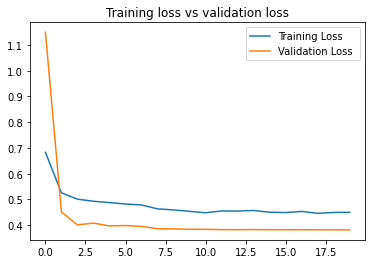

In [ ]:
x = [i for i in np.arange(0, 20)]
plt.plot(x, loss1, Label = 'Training Loss')
plt.plot(x, loss2, Label = 'Validation Loss ')
plt.legend(loc = 'upper right')
plt.title("Training loss vs validation loss")
plt.show()

In [ ]:
a, b = next(iter(train))

In [ ]:
b

tensor([4])

In [ ]:
train = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True, num_workers = 2)

In [ ]:
c = model(a)

In [ ]:
a.shape

torch.Size([1, 3, 224, 224])

In [ ]:
a.get_device()

-1

In [ ]:
a.to(device)

tensor([[[[-2.1189, -2.1189, -2.0995,  ..., -2.0801, -2.0801, -2.0801],
          [-2.1189, -2.1189, -2.0995,  ..., -2.0801, -2.0801, -2.0801],
          [-2.1189, -2.1189, -2.0995,  ..., -2.0608, -2.0608, -2.0608],
          ...,
          [-1.9251, -1.9251, -1.9251,  ..., -1.7118, -1.7118, -1.7118],
          [-1.9251, -1.9251, -1.9251,  ..., -1.7118, -1.7118, -1.7118],
          [-1.9251, -1.9251, -1.9251,  ..., -1.7118, -1.7118, -1.7118]],

         [[-1.9463, -1.9463, -1.9266,  ..., -2.0053, -2.0053, -2.0053],
          [-1.9463, -1.9463, -1.9266,  ..., -1.9856, -1.9856, -1.9856],
          [-1.9463, -1.9463, -1.9069,  ..., -1.9856, -1.9856, -1.9856],
          ...,
          [-1.7299, -1.7299, -1.7299,  ..., -1.6119, -1.6119, -1.6119],
          [-1.7299, -1.7299, -1.7299,  ..., -1.6119, -1.6119, -1.6119],
          [-1.7496, -1.7496, -1.7496,  ..., -1.6119, -1.6119, -1.6119]],

         [[-1.9873, -1.9873, -1.9678,  ..., -2.0458, -2.0263, -2.0263],
          [-1.9873, -1.9873, -

In [ ]:
d = get_device(a)

NameError: ignored

In [ ]:
a

tensor([[[[-2.1189, -2.1189, -2.0995,  ..., -2.0801, -2.0801, -2.0801],
          [-2.1189, -2.1189, -2.0995,  ..., -2.0801, -2.0801, -2.0801],
          [-2.1189, -2.1189, -2.0995,  ..., -2.0608, -2.0608, -2.0608],
          ...,
          [-1.9251, -1.9251, -1.9251,  ..., -1.7118, -1.7118, -1.7118],
          [-1.9251, -1.9251, -1.9251,  ..., -1.7118, -1.7118, -1.7118],
          [-1.9251, -1.9251, -1.9251,  ..., -1.7118, -1.7118, -1.7118]],

         [[-1.9463, -1.9463, -1.9266,  ..., -2.0053, -2.0053, -2.0053],
          [-1.9463, -1.9463, -1.9266,  ..., -1.9856, -1.9856, -1.9856],
          [-1.9463, -1.9463, -1.9069,  ..., -1.9856, -1.9856, -1.9856],
          ...,
          [-1.7299, -1.7299, -1.7299,  ..., -1.6119, -1.6119, -1.6119],
          [-1.7299, -1.7299, -1.7299,  ..., -1.6119, -1.6119, -1.6119],
          [-1.7496, -1.7496, -1.7496,  ..., -1.6119, -1.6119, -1.6119]],

         [[-1.9873, -1.9873, -1.9678,  ..., -2.0458, -2.0263, -2.0263],
          [-1.9873, -1.9873, -